In [1]:
library(gtools)
library(dplyr)
library(ggplot2)

Warning message:
"package 'gtools' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
# load data
inTeams<-read.csv("https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv")

In [3]:
# PRE SIMULATION WORK

In [4]:
# Prize dataframe
ranks <- 1:20
prizes <- matrix(ranks, nrow=20, ncol=1, byrow=FALSE)
prizes <- as.data.frame(prizes)
colnames(prizes) <- c('team_rank')
prizes$prize <- c(225,210,200,190,160,150,140,125,123,120,118,115,112,110,108,105,100,52,50,49)

In [5]:
# taking averages
mean.off<-mean(inTeams$off)
mean.def<-mean(inTeams$def)
lmean.off<-mean(log(inTeams$off))
lmean.def<-mean(log(inTeams$def)) 

# subset to premier league
premLeague<-subset(inTeams,league=="Barclays Premier League")
premTeams<-premLeague$name
rownames(premLeague)<-premTeams
df.prem<-premLeague[,c("off","def")]

# build parameters
lmean.def<- log(mean(df.prem$def))
lmean.off<- log(mean(df.prem$off))               
df.prem["alpha"]<-log(df.prem["off"])-lmean.def
df.prem["delta"]<-lmean.off-log(df.prem["def"])
alphaList<-df.prem$alpha
deltaList<-df.prem$delta
names(alphaList)<-rownames(df.prem)
names(deltaList)<-rownames(df.prem)

In [6]:
# simulate score line for a match
draw.score<-function(team1,team2){
    c(
        rpois(1,exp(alphaList[team1]-deltaList[team2])),
  rpois(1,exp(alphaList[team2]-deltaList[team1]))
    )
}
draw.score("Liverpool","Arsenal")

[1] 0 1

In [20]:
# All possible matches in a season
allMatches<-permutations(20, 2, v=rownames(df.prem),repeats.allowed=FALSE)
colnames(allMatches)<-c("home","away")
allMatches
nrow(allMatches)

home,away
Arsenal,Aston Villa
Arsenal,Brentford
Arsenal,Brighton and Hove Albion
Arsenal,Burnley
Arsenal,Chelsea
Arsenal,Crystal Palace
Arsenal,Everton
Arsenal,Leeds United
Arsenal,Leicester City
Arsenal,Liverpool


[1] 380

In [8]:
# SIMULATION

In [18]:
SeasonSim <- function(allMatches){
     ScoresMatrix <- matrix(nrow=nrow(allMatches),  ncol=4)
        for (ii in 1:nrow(allMatches)  ) {
         ScoresMatrix[ii,1:2]=allMatches[ii,]
         ScoresMatrix[ii,3:4]= as.numeric(draw.score(allMatches[ii,"home"],allMatches[ii,"away"] ))
        }
        colnames(ScoresMatrix)<-c("home.team","away.team","home.score","away.score")
        ScoresMatrix <- as.data.frame(ScoresMatrix)
        ScoresMatrix$home.score <- as.numeric(ScoresMatrix$home.score)
        ScoresMatrix$away.score <- as.numeric(ScoresMatrix$away.score)  
        ScoresMatrix
    
        # PEPARING AGGREGATE STATS DFs
        df.points <- as.data.frame(ScoresMatrix)
        df.points_goalsfor <- as.data.frame(ScoresMatrix)
        df.points_goalsagainst <- as.data.frame(ScoresMatrix)
        name <- rownames(df.prem)
        for (i in 1:20){
            df.points[, name[i]] <- 0
        }
        # ASSIGNING POINTS PER MATCH
        for (i in 1:380){ 
            for (j in 1:20){
                if (df.points[i,1] == name[j]){
                    if (df.points[i,3] > df.points[i,4]){
                        df.points[i,j+4] = 3
                    } else if (df.points[i,3] == df.points[i,4]){
                        df.points[i,j+4] = 1
                    } else if (df.points[i,3] < df.points[i,4]){
                        df.points[i,j+4] = 0
                    } 
                } 
                if (df.points[i,2] == name[j]){
                    if (df.points[i,3] > df.points[i,4]){
                        df.points[i,j+4] = 0
                    } else if (df.points[i,3] == df.points[i,4]){
                        df.points[i,j+4] = 1
                    } else if (df.points[i,3] < df.points[i,4]){
                        df.points[i,j+4] = 3
                    }      
                }
            }   
        } 
        df.points
    
        # PREPARING DFs
        for (i in 1:20){
            df.points_goalsfor[, name[i]] <- 0
        }
        for (i in 1:20){
            df.points_goalsagainst[, name[i]] <- 0
        }
    
        # GOALS FOR
        for (i in 1:380){
            for (j in 1:20){
                if (df.points_goalsfor[i,1] == name[j]){ # looking at home team
                    df.points_goalsfor[i,j+4] = df.points_goalsfor[i,3]  # home points go to goals for
                }
                if (df.points_goalsfor[i,2] == name[j]){ # looking at away team
                    df.points_goalsfor[i,j+4] = df.points_goalsfor[i,4] # away points go to goals for
                }
            }
        }
        df.points_goalsfor
    
        # GOALS AGAINST
        for (i in 1:380){
            for (j in 1:20){
                if (df.points_goalsagainst[i,1] == name[j]){ # looking at home team
                    df.points_goalsagainst[i,j+4] = df.points_goalsagainst[i,4]  # home points go to goals for
                }
                if (df.points_goalsagainst[i,2] == name[j]){ # looking at away team
                    df.points_goalsagainst[i,j+4] = df.points_goalsagainst[i,3] # away points go to goals for
                }
            }
        } 
        df.points_goalsagainst
    
        # AGGREGATING POINTS and GOALS
        points <- df.points[,c(-1,-2,-3,-4)]
        points <- sapply(points, as.numeric)
        points_sum <- as.data.frame(colSums(points))
    
        goalsfor <- df.points_goalsfor[,c(-1,-2,-3,-4)]
        goalsfor <- sapply(goalsfor, as.numeric)
        goalsfor_sum <- as.data.frame(colSums(goalsfor))

        goalsagainst <- df.points_goalsagainst[,c(-1,-2,-3,-4)]
        goalsagainst <- sapply(goalsagainst, as.numeric)
        goalsagainst_sum <- as.data.frame(colSums(goalsagainst))
    
        # MERGE TO ONE DF
        df.teams <- cbind(points_sum, goalsfor_sum, goalsagainst_sum)
        colnames(df.teams)[1] <- 'points'
        colnames(df.teams)[2] <- 'goals_for'
        colnames(df.teams)[3] <- 'goals_against'
        df.teams$team_names <- row.names(df.teams)
        df.teams
    
        # ADD TIE BREAKER VARIABLES
        df.teams <- df.teams %>%
            mutate(net_goals = goals_for - goals_against) %>%
            mutate(tie_breaker = runif(20, 0, 1))
    
        df.teams1 <- df.teams
        df.teams1$temp_team_rank <- rank(desc(df.teams1$points))
        df.teams1$goals_rank <- rank(desc(df.teams1$net_goals))
        df.teams1$goalsfor_rank <- rank(desc(df.teams1$goals_for))
    
        # RANK 
        for (ii in 1:nrow(df.teams1)){
            for (jj in 1:nrow(df.teams1)){
                if (ii != jj & df.teams1[ii,7] == df.teams1[jj,7]){
                    if (df.teams1[ii,8] > df.teams1[jj,8]){ #goals rank
                        df.teams1[ii,7] = df.teams1[ii,7]+0.5
                        df.teams1[jj,7] = df.teams1[jj,7]-0.5
                    } else if (df.teams1[ii,8] == df.teams1[jj,8]){ #goals_for rank
                        if (df.teams1[ii,9] > df.teams1[jj,9]){
                            df.teams1[ii,7] = df.teams1[ii,7]+0.5
                            df.teams1[jj,7] = df.teams1[jj,7]-0.5
                        } else if (df.teams1[ii,9] == df.teams1[jj,9]){                   
                            if (df.teams1[ii,6] > df.teams1[jj,6]){
                            df.teams1[ii,7] = df.teams1[ii,7]+0.5
                            df.teams1[jj,7] = df.teams1[jj,7]-0.5
                            }   
                        }
                    }
                }
            }
        }
        df.teams1
        df.teams1$team_rank <- rank(df.teams1$temp_team_rank)
        # ASSIGN PRIZE
        df.earnings <- left_join(df.teams1, prizes, by=c("team_rank"))
        head(df.earnings)
    }

In [19]:
# results df
finalcol <- c("points", "goals_for", "goals_against", "team_names", "net_goals", "tie_breaker", "team_rank", "goals_rank", "goalsfor_rank", "prize")
df.final.output <- as.data.frame(matrix(ncol = length(finalcol), nrow=0, dimnames = list(NULL,finalcol)))

# simulations
nsims <- 10

# simulation
for (rep in 1:nsims) {
    df.sim.earnings <- SeasonSim(allMatches)
    df.sim.earnings$sim <- rep
    df.final.output <- rbind(df.final.output, df.sim.earnings)
}
df.final.output

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,goals_rank,goalsfor_rank,team_rank,prize,sim
83,101,47,Manchester City,54,0.974417489,2,2.0,2.0,2,210,1
98,107,46,Liverpool,61,0.106433839,1,1.0,1.0,1,225,1
70,88,53,Chelsea,35,0.127885606,3,3.0,3.0,3,200,1
51,72,64,Arsenal,8,0.466513537,7,5.5,14.0,7,140,1
47,74,78,Tottenham Hotspur,-4,0.825629968,11,9.5,9.5,11,118,1
58,74,66,Manchester United,8,0.757058321,4,5.5,9.5,4,190,1
89,105,50,Manchester City,55,0.200022624,1,1.0,1.0,1,225,2
83,101,55,Liverpool,46,0.738165813,2,2.0,2.0,2,210,2
75,87,47,Chelsea,40,0.213644526,3,3.0,3.0,3,200,2
62,76,58,Arsenal,18,0.684761514,7,5.0,9.0,7,140,2


***ANALYSIS***
1. Assemble a ranking of the teams from best to worst according to their expected position in the table.
    Illustrate this ranking with a clear visualization
2. Which teams have the most variability in their simulated earnings?
    Again, illustrate this variability with a clear visualization.
3. Which teams stand to benefit the most in monetary terms from a "lucky win" (converting one of their losses to a win)?
    Again provide a visualization of this marginal effect
4. Finally, for each team, calculate the monetary benefit to each team from either (i) an increase of 10% to their expected goals scored (holding everyone else constant), or (ii) a decreasing in their expected goals conceded by 10% (Note that this means 40 separate simulations!)
    Use this to provide a clear visualization of the benefits of investing in offense versus defense by team

***1. Teams by best to worst expected position***

In [15]:
head(df.final.output)
# taking averages
df.summary <- df.final.output %>%
    group_by(team_names) %>%
    mutate(avg_rank = mean(team_rank)) %>%
    mutate(avg_prize = mean(prize)) %>%
    mutate(variability = sd(team_rank)) # sqrt of the variance

df.analysis <- select(df.summary, c(4,13,14,15))
df.analysis = unique(df.analysis)
df.analysis


points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,goals_rank,goalsfor_rank,team_rank,prize,sim
79,94,52,Manchester City,42,0.7876436,1,1.0,1.5,1,225,1
75,94,60,Liverpool,34,0.6509236,3,2.0,1.5,3,200,1
78,89,56,Chelsea,33,0.3065557,2,3.0,3.0,2,210,1
72,82,56,Arsenal,26,0.6771965,4,4.0,6.5,4,190,1
59,76,71,Tottenham Hotspur,5,0.6625444,7,8.5,12.5,7,140,1
63,82,71,Manchester United,11,0.9997283,5,5.0,6.5,5,160,1


team_names,avg_rank,avg_prize,variability
Manchester City,1.670,215.85,0.7792122
Liverpool,1.910,212.70,0.8299325
Chelsea,2.690,203.35,0.9712535
Arsenal,5.135,NA,1.8570844
Tottenham Hotspur,6.680,151.01,2.6357296
Manchester United,7.840,138.36,2.8274270


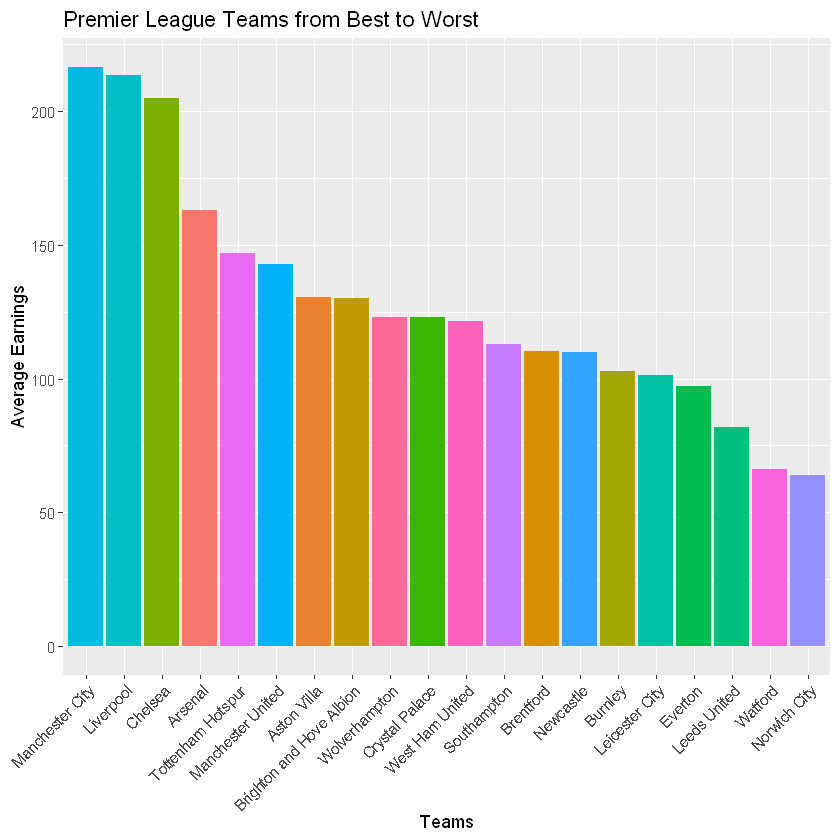

In [56]:
# Visualize rankings/earnings
ggplot(df.analysis, aes(x=reorder(team_names,-avg_prize), y=avg_prize, fill=team_names)) + 
  geom_bar(stat = "identity") +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Average Earnings') +
  ggtitle('Premier League Teams from Best to Worst') +
  theme(legend.position="none")

***2. Which teams have the most variability in their simulated earnings?***
Brentford, Burnley, Wolverhampton (based off of sensitive measure of variability)

Visualizing the range of earnings per team:
Resistance measure (interquartile range)

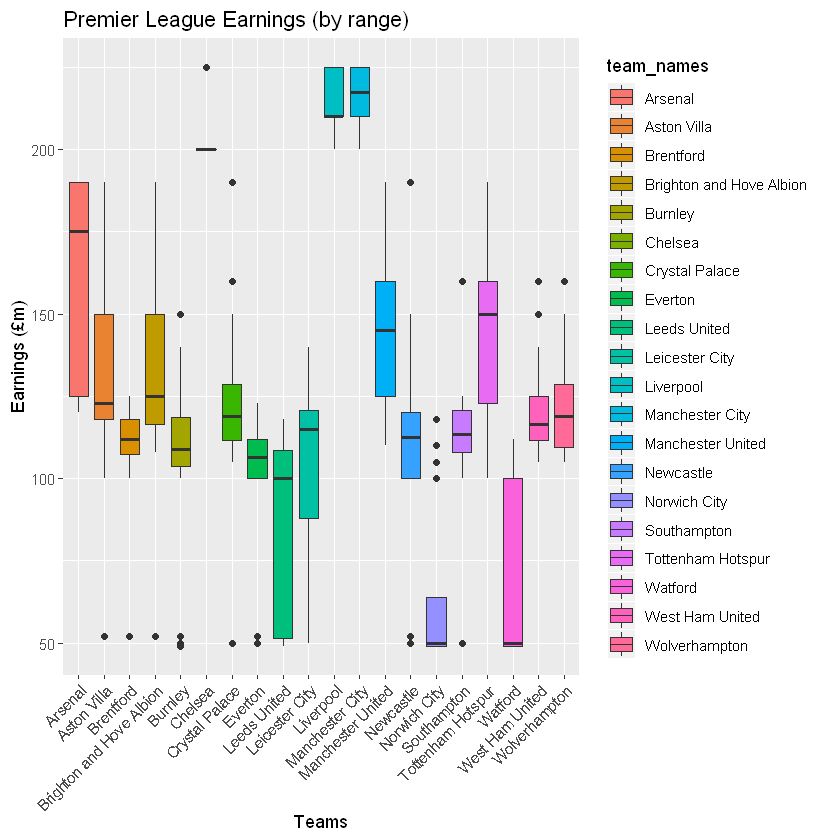

In [57]:
ggplot(df.summary, aes(x=team_names, y=prize, fill=team_names)) +
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    xlab('Teams') +
    ylab('Earnings (£m)') +
    ggtitle('Premier League Earnings (by range)')

Standard deviation (sensitive measure):
Use given we won't have extreme outliers since our model doesn't account for shocks

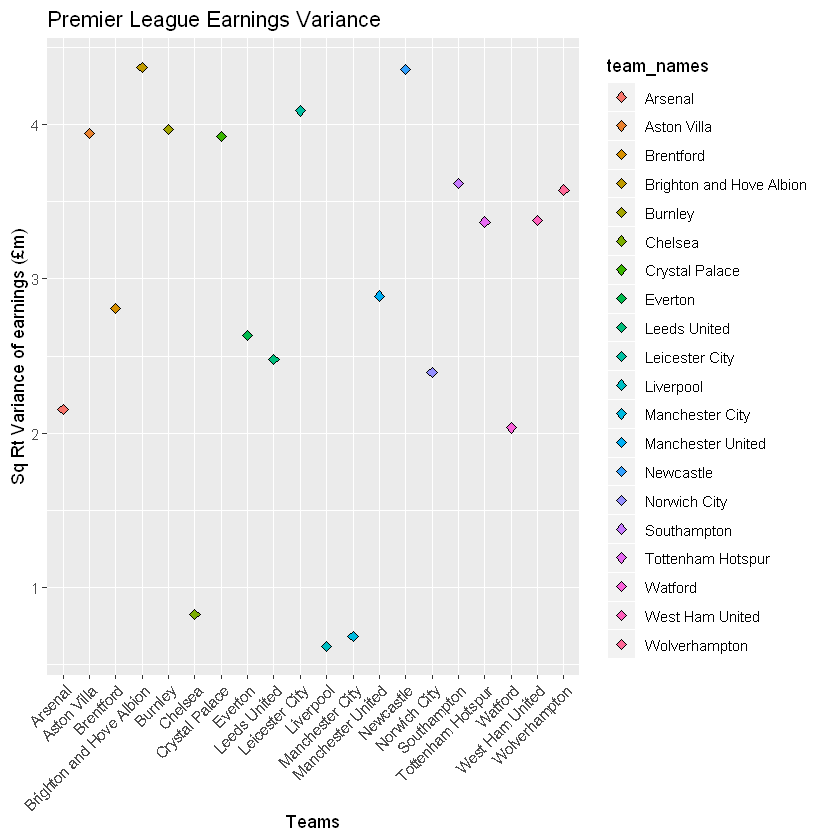

In [58]:
ggplot(df.analysis, aes(x=team_names, y=variability, fill=team_names)) +
  geom_point(size=2, shape=23) +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    xlab('Teams') +
    ylab('Sq Rt Variance of earnings (£m)') +
    ggtitle('Premier League Earnings Variance')

***3. Which teams stand to benefit the most in monetary terms from a "lucky win" (converting one of their losses to a win)? (visualization of marginal effect)***

In [59]:
head(df.summary)

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,goals_rank,goalsfor_rank,team_rank,prize,sim,avg_rank,avg_prize,variability
76,82,49,Manchester City,33,0.5532685,3,2.0,5.5,3,200,1,1.60,216.50,0.6805570
79,98,50,Liverpool,48,0.8564774,2,1.0,1.0,2,210,1,1.80,213.50,0.6155870
81,84,52,Chelsea,32,0.3396206,1,3.0,4.0,1,225,1,2.60,205.00,0.8207827
54,69,68,Arsenal,1,0.4541163,9,9.0,14.0,9,123,1,5.70,163.05,2.1545545
67,90,71,Tottenham Hotspur,19,0.5664507,5,4.5,2.0,5,160,1,7.25,146.80,3.3697571
56,79,70,Manchester United,9,0.6314269,8,8.0,7.0,8,125,1,7.35,142.75,2.8887258


In [60]:
# clean appropriate variables
df.summary$prize <- as.numeric(df.summary$prize)
df.summary$points <- as.numeric(df.summary$points)
df.summary$goals_for <- as.numeric(df.summary$goals_for)
df.summary$goals_against <- as.numeric(df.summary$goals_against)
df.summary$net_goals <- as.numeric(df.summary$net_goals)
df.summary$tie_breaker <- as.numeric(df.summary$tie_breaker)
df.summary$team.f <- factor(df.summary$team_names)

reg1 <- lm(prize ~ points + team.f + team.f*points, data=df.summary) 
summary(reg1)


Call:
lm(formula = prize ~ points + team.f + team.f * points, data = df.summary)

Residuals:
    Min      1Q  Median      3Q     Max 
-38.917  -6.115   0.038   6.508  32.447 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           -47.89495   22.87442  -2.094 0.036975 *  
points                                  3.39960    0.36583   9.293  < 2e-16 ***
team.fAston Villa                      12.22043   29.43037   0.415 0.678219    
team.fBrentford                        56.15576   34.17901   1.643 0.101258    
team.fBrighton and Hove Albion          7.14785   27.10240   0.264 0.792135    
team.fBurnley                           5.90639   28.30864   0.209 0.834845    
team.fChelsea                         157.65884   46.17183   3.415 0.000712 ***
team.fCrystal Palace                   33.16739   27.82452   1.192 0.234038    
team.fEverton                          22.16356   31.17305   0.711 0.477554    
team.fLee

In [ ]:
# plot
ggplot(dummy, aes(x=x, y=predicted)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), alpha = .9,position = position_dodge())+
  labs(
    x="Sex",
    y="Salary",
    title="The Marginal Effect of Sex on Salary"
  )+scale_x_continuous(breaks=c(1,2) ,labels = c("Female", "Male"))

***4. Finally, for each team, calculate the monetary benefit to each team from either 
    (i) an increase of 10% to their expected goals scored (holding everyone else constant), or 
    (ii) a decreasing in their expected goals conceded by 10% (Note that this means 40 separate simulations!)***
    
    Use this to provide a clear visualization of the benefits of investing in offense versus defense by team